In [392]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [393]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) #bias = False?
        self.relu1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.multiplier = np.sqrt(hidden_size)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.output_layer(x)
        x = x*self.multiplier
        return x

# Set random seed for reproducibility
torch.manual_seed(42)

# Define synthetic input data
input_size = 20
synthetic_input = torch.rand(input_size)

# Instantiate the neural network
hidden_size = 20
output_size = 1
model = FeedforwardNN(input_size, hidden_size, output_size)

# Forward pass
output = model(synthetic_input)

# Print the architecture and output shape
print(model)
print("Output shape:", output.shape)

FeedforwardNN(
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (relu1): ReLU()
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)
Output shape: torch.Size([1])


In [394]:
initial_weights = model.state_dict()

In [395]:
p = 0
for name, param in model.named_parameters():
    if 'weight' in name:
        x,y = param.size()
        p += x*y
        print(f'Layer: {name}, Size: {param.size()}')
print('Number of parameters:',p)

Layer: layer1.weight, Size: torch.Size([20, 20])
Layer: output_layer.weight, Size: torch.Size([1, 20])
Number of parameters: 420


In [396]:
def random_ball(num_points,dimension,radius = 1):
    output = []
    for n in range(num_points):
        x = np.random.randn(20)
        x /= np.linalg.norm(x, ord=2)
        x = torch.tensor(x,dtype = torch.float32)
        if num_points == 1:
            return x
        output.append(x)
    return torch.stack(output)

In [397]:
# Simulated Reward Function
# Careful: Adding noise breaks it as the noise takes over. But noise doesn't break if the reward is high
a = random_ball(1,20,1).reshape(-1)
def reward_function(context):
    return 10*(torch.dot(context,a)**2).item() + (0.1*torch.randn(1)).item()
reward_function(torch.rand(20))

2.1344616785645485

In [398]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predicted, target,flattened_initial_weights,flattened_current_weights):
        loss = (0.5*torch.sum((predicted - target)**2))/target.shape[0]
#         m = 20
#         lamb = 1
#         norm = 0.5*m*lamb*(torch.norm(flattened_initial_weights - flattened_current_weights, p=2)**2)
        return loss

In [399]:
def train_nn(input_data,best_rewards,initial_weights,J = 20):
    model_inside = FeedforwardNN(input_size, hidden_size, output_size)
    model_inside.load_state_dict(initial_weights)

    loss_function = CustomLoss()

    optimizer = optim.SGD(model_inside.parameters(),lr = 0.001) # Need to fix to GD?
    size = len(input_data)
    rewards = torch.tensor(best_rewards).reshape(-1,1)
    dataset = TensorDataset(input_data,rewards)
#     print('dataset',input_data)
#     print('r',rewards)

    batch_size = 50
    shuffle = True  # Set to True if you want to shuffle the data
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)    

    flattened_initial_weights = torch.cat([p.flatten() for p in initial_weights.values()])
    
    for j in range(J):
        for inputs,targets in data_loader:
            optimizer.zero_grad()
            output = model_inside(inputs)
            current_weights = model_inside.state_dict()
            flattened_current_weights = torch.cat([p.flatten() for p in current_weights.values()])
            loss = loss_function(output, targets,flattened_initial_weights,flattened_current_weights)
            loss.backward()
            optimizer.step()
    print('loss j',j,loss)
        
    print('--------------------------------------')

    model_weights = model_inside.state_dict()
    return model_weights

In [400]:
def get_regret(data,best_action,reward_function):
    best_reward = -np.inf
    rewards = []
    for idx,t in enumerate(data):
        reward = reward_function(t)
        if reward > best_reward:
            best_reward = reward
            best_idx = idx
            
        rewards.append(reward)
            
    chosen_reward = rewards[best_action]
    regret = best_reward - chosen_reward
    return regret

In [401]:
def NeuralUCB(model, T, lamb = 0.2, v = 0.2, delta = 0.2, norm = 0.2, step_size = 0.2, num_iter = 10):
    Z = torch.eye(p)
    K = 4
    dim = 20 # feature vector dimension (context)
    m = 20 # Neural Network width
    gamma = 1
    best_contexts = []
    best_rewards = []
    regrets = []
    for t in range(T):
#         synthetic_input = torch.rand(K,dim)
        synthetic_input = random_ball(K,dim) # "K" arms x "dim" feature size
        all_grad = []
        ucbs = []
        for k in range(K):
            output = model(synthetic_input[k])
            model.zero_grad()
            output.backward(torch.ones_like(output),retain_graph = True)
            g = []
            for name, param in model.named_parameters():
                if 'weight' in name:
                    tmp = param.grad.flatten()
                    g.append(tmp)
            g = torch.cat(g,dim = 0).reshape(-1,1)
    
    
            Z_inv = torch.inverse(Z)
            
            
            all_grad.append(g)
            exploration_reward = gamma*torch.sqrt((g.T@Z_inv@g)/m) 
            ucb_a = output + exploration_reward
            ucbs.append(ucb_a.item())
            
            
        ucbs = torch.tensor(ucbs)
        best_action = torch.argmax(ucbs).item()
        best_context = synthetic_input[best_action]
        best_g = all_grad[best_action]
        best_reward = reward_function(best_context)
        Z = Z + (best_g@best_g.T/m)
        
        best_contexts.append(best_context)
        
        
        best_rewards.append(best_reward)
        
        
        
        if (t+1)%50 == 0:
            ### Train Neural Network
            new_weights = train_nn(torch.stack(best_contexts),torch.tensor(best_rewards),initial_weights,J = t+1)
            model.load_state_dict(new_weights)
            print(f'Training NN step {t+1}')
            print(np.sum(regrets))

        regret = get_regret(synthetic_input,best_action,reward_function)
        regrets.append(regret)
        
        # Update gamma: To be updated        
        
        
        
    return model,regrets

### Quadratic function

In [402]:
model,regrets = NeuralUCB(model,1000)

C:\Users\chana\AppData\Local\Temp\ipykernel_17480\3245520253.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(best_rewards).reshape(-1,1)


loss j 49 tensor(0.3672, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 50
39.07221081947495
loss j 99 tensor(0.3424, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 100
68.22902163723364
loss j 149 tensor(0.2714, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 150
104.66749203848002
loss j 199 tensor(0.3341, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 200
139.58290636080994
loss j 249 tensor(0.1742, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 250
179.34657465164048
loss j 299 tensor(0.2001, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 300
197.88991938407264
loss j 349 tensor(0.0861, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 350
221.11209354708728
loss j 399 tensor(0.0837, grad_fn=<DivBackward0>)
--------------------------------------
Training NN s

In [403]:
def plot_cumulative(data):
    cumulative_sum = np.cumsum(data)
    plt.plot(cumulative_sum)
    plt.xlabel('Index')
    plt.ylabel('Cumulative Sum')
    plt.title('Cumulative Sum Plot')
    plt.grid(True)
    plt.show()

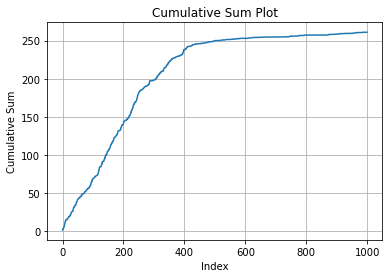

In [404]:
plot_cumulative(regrets)

## cos function

In [410]:
a = random_ball(1,20,1).reshape(-1)
def reward_function(context):
    return np.cos(3*(torch.dot(context,a)).item()) + (0.1*torch.randn(1)).item()
reward_function(torch.rand(20))

0.6615888421660129

In [411]:
model,regrets = NeuralUCB(model,1000)

C:\Users\chana\AppData\Local\Temp\ipykernel_17480\3245520253.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(best_rewards).reshape(-1,1)


loss j 49 tensor(0.0290, dtype=torch.float64, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 50
9.04425505506133
loss j 99 tensor(0.0428, dtype=torch.float64, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 100
19.557647396251593
loss j 149 tensor(0.0279, dtype=torch.float64, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 150
33.703277594538974
loss j 199 tensor(0.0625, dtype=torch.float64, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 200
43.46880265520119
loss j 249 tensor(0.0475, dtype=torch.float64, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 250
54.37866910040106
loss j 299 tensor(0.0388, dtype=torch.float64, grad_fn=<DivBackward0>)
--------------------------------------
Training NN step 300
64.28362073740006
loss j 349 tensor(0.0241, dtype=torch.float64, grad_fn=<DivBackward0>)
-------------------------------------

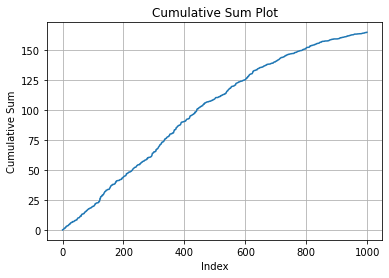

In [412]:
plot_cumulative(regrets)

### Result Testing

In [416]:
test = torch.rand((4,20))

In [417]:
best_idx = 0
best_reward = 0
for idx,t in enumerate(test):
    reward = reward_function(t)
    if reward>best_reward:
        best_reward = reward
        best_idx = idx
    print(f'idx_{idx} reward: ',reward)

idx_0 reward:  0.9955467944920006
idx_1 reward:  0.3881474446373362
idx_2 reward:  0.9013709389045763
idx_3 reward:  0.37688870821503956


In [418]:
model(test)

tensor([[1.0867],
        [0.0552],
        [0.9396],
        [0.3019]], grad_fn=<MulBackward0>)